# Annual outlet glacier terminus positions in northwestern Greenland


In [1]:
# Import modules
import sys
sys.path.append('/mnt/e/')

import os
import geopandas as gpd
import pandas as pd
import GlacierClass as gc
import metrics as met
import plotlib as gpl
import climate as clm
import climplotlib as cpl
import utilities as utils
import plotutils as plu
import matplotlib.pyplot as plt
from shapely.ops import Point
import cartopy.crs as ccrs
import numpy as np
import pwlf
import matplotlib.ticker as mticker
import rasterio as rio
import matplotlib.colors as colors
import matplotlib.cm as cm

/home/taryn/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# User Parameters

# -- Glacier geodatabase
# ---- relative path for file geodatabase container glacier information
fgdb = '/mnt/e/northwest-decadal/gis-data/nwgreenland_decadal.gdb'
# ---- file geodatabase layer names
termini_layer = 'annual_termini'
points_layer = 'glacier_points'
boxes_layer = 'glacier_boxes'

# -- Climate directories and variables
ecco_sst_dir = '/mnt/e/data/ECCO-V5alpha/'
icesdk_file = '/mnt/e/data/ices_dk_NWGreenland_ocntemp/1118187b.csv'
hadley_sst_dir = '/mnt/e/data/hadley-oi/SST/'
ecco_sic_dir = '/mnt/e/data/ECCO_v5alpha/SIarea/'
hadley_sic_dir = '/mnt/e/data/hadley-oi/ICE/'
noaa_sic_dir = '/mnt/e/data/NSIDC_NOAA_G02202V3_monthly_sic/'
noaa_var = 'goddard_merged_seaice_conc_monthly'
mar_dir = '/mnt/e/data/MARv3.11/ERA_1979-2020-6km/'
fglacier_points = '/mnt/e/northwest-decadal/northwest_decadal_2021/glacier_points.csv'

# -- Other data files
oceanmask_file = '/mnt/e/data/GimpOceanMask_90m/GimpOceanMask_90m.shp'
bedmachine_file = '/mnt/e/data/BedMachineGreenland_v3/BedMachineGreenland_Bed250m.tif'
measures_file = '/mnt/e/data/MEaSUREs_Greenland_20yr_velocity_v1/greenland_vel_mosaic_v_v1_500m.tif'

# -- Relative path to save figure output
outpath = '/mnt/e/northwest-decadal/manuscript/figs/'

# -- Spatial bounds
ocean_bounds = [82, 68, -40, -76]
ice_bounds = [79, 68, -47, -74]
ocean_depth = 250
topo_range = [0, 1000]

# -- Temporal bounds
times = ['1972-09-01', '2020-08-31']

# -- Thresholds
sic_minimum = 15
ice_minimum = 90

# -- Discrete sampling points
ocean_points = [(69.00, -53.00),#(69.25, -52.25)
                (70.85, -54.25),
                (73.25, -58.00),
                (74.50, -60.00),
                (75.50, -62.00),#(75.70, -61.75)
                (75.75, -65.00),
                (76.25, -71.00),
                (77.00, -72.00)]#(77.00, -72.50)]
ocean_point_names = ['Disko Bay',
                     'Uummannaq Fjord',
                     'Upernavik Icefjord',
                     'South Melville Bay',
                     'Central Melville Bay',
                     'North Melville Bay',
                     'Wolstenholme Bay',
                     'Inglefield Fjord']
glacier_points = pd.read_csv(fglacier_points)
glacier_coords = [(glacier_points.iloc[g].Latitude, glacier_points.iloc[g].Longitude) for g in glacier_points.index]

# -- Geographic information (for plotting)
projection = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

# -- Select figure formatting style and set default figure properties
style = 'pub-cryo'
figformat = 'pdf'
figwidth = plu.figureWidth(style)
plu.globalDesignProperties(style)

In [3]:
# GLACIER DATA ANALYSIS

# -- Load glacier data
termini = gpd.read_file(fgdb, layer=termini_layer, driver='FileGDB')

points = gpd.read_file(fgdb, layer=points_layer, driver='FileGDB')
points.sort_values(by='Glacier_ID', inplace=True)
points.set_index('Glacier_ID', drop=False, inplace=True)

refboxes = gpd.read_file(fgdb, layer=boxes_layer, driver='FileGDB')
refboxes.sort_values(by='Glacier_ID', inplace=True)
refboxes.set_index('Glacier_ID', drop=False, inplace=True)

# -- Get scope of glaciers and time
GIDS = points.Glacier_ID.values

termini['Year'] = pd.to_datetime(termini['Year'], format='%Y')
YEAR_START = termini.Year.min().year
YEAR_END = termini.Year.max().year
YEARS = range(YEAR_START, YEAR_END)

DATE_START = termini.Source_Date.min()
DATE_END = termini.Source_Date.max()

# -- Initialize dictionary of Glacier objects to store glacier information
all_glaciers = {id: gc.Glacier(id) for id in GIDS}
for id in all_glaciers:
    all_glaciers[id].refbox = refboxes.loc[id].geometry
    all_glaciers[id].officialname = points.loc[id].Official_Name
    all_glaciers[id].greenlandicname = points.loc[id].Greenlandic_Name
    all_glaciers[id].alternativename = points.loc[id].Alternative_Name

# -- Construct an observation time series for each glacier
for id in GIDS:

    # get reference line and all observations for glacier ID
    glacier = termini.query('Glacier_ID == @id')
    # refbox = all_glaciers[id].refbox

    # loop through all observations and process data
    for n in range(len(glacier)):
        observation = glacier.iloc[n]

        # create a Terminus Observation for a row in geodataframe
        obs = gc.TerminusObservation(gid=int(observation.Glacier_ID),
                                     qflag=observation.Quality_Flag,
                                     termination='',
                                     imageid=observation.Image_ID,
                                     sensor=observation.Sensor,
                                     date=pd.to_datetime(
                                         observation.Source_Date),
                                     terminus=observation.geometry,
                                     referencebox=all_glaciers[id].refbox)

        # add glacier observation to time series
        all_glaciers[id].addObservation(obs)
    
    # update all attribute series for glacier
    all_glaciers[id].updateObservedValues()
    all_glaciers[id].updateDerivedValues(YEARS)

Text(0.5, 1.0, 'Glacier retreat in northwestern and central-west Greenland')

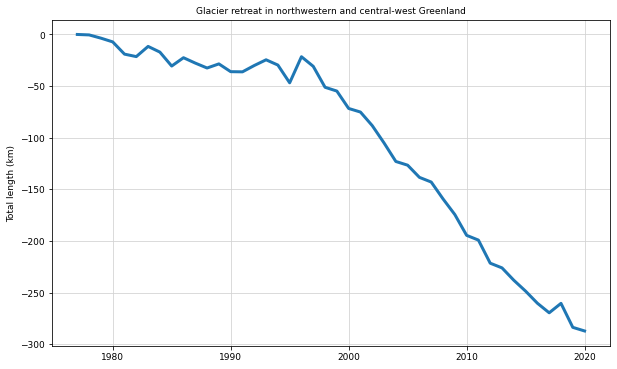

In [56]:
glacier_lengths = pd.DataFrame(columns=range(1977,2021), index=GIDS)
for id in GIDS:
    glacier = all_glaciers[id]
    lengths = pd.Series(glacier.interplengths.lengths.values, index=glacier.interplengths.index)
    lengths = lengths - lengths.loc[1977]
    glacier_lengths.loc[id] = lengths
cum_glacier_lengths = glacier_lengths.sum()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cum_glacier_lengths.index, cum_glacier_lengths.values, linewidth=3)
ax.set_ylabel('Total length (km)')
ax.set_title('Glacier retreat in northwestern and central-west Greenland')

# Figure 1: Northwest Greenland study area

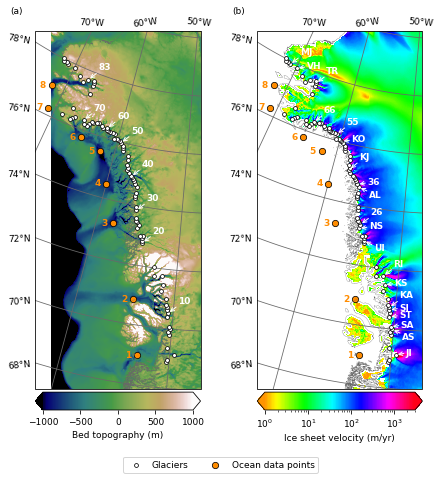

In [4]:
# -- Load GIMP ocean mask
gimp = gpd.read_file(oceanmask_file)
gimp.to_crs(points.crs)

# -- 0: Common features between both plots (function)
def plot_common_map_features(ax, gimp, points, ocean_points):
    # -- Set map boundaries based on observed region + some buffer
    bounds = points.total_bounds
    bound_buffer = 100000
    ax.set_xlim([bounds[0]-bound_buffer, bounds[2]+bound_buffer])
    ax.set_ylim([bounds[1]-bound_buffer, bounds[3]+bound_buffer])
    # -- Set gridline properties to display as lat/lon and below other features
    gl = ax.gridlines(
        transform=ccrs.Geodetic(), 
        draw_labels=True,
        x_inline=False,
        y_inline=False,
        color='dimgray',
        zorder=0.5)
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-70, -60, -50])
    # -- Convert ocean points to geographic data
    xy_ocean_points = [(c[1], c[0]) for c in ocean_points]
    ocean_zones = gpd.GeoDataFrame({'geometry': [Point(c) for c in xy_ocean_points]}, crs='EPSG:4326')
    ocean_zones = ocean_zones.to_crs(points.crs)
    # -- Plot Greenland outline, glacier points, and ocean points
    gimp.plot(ax=ax, linewidth=0.25, color='dimgray')
    points.plot(ax=ax, markersize=15, color='white', edgecolor='black', linewidth=0.75, zorder=2, label='Glaciers')
    ocean_zones.plot(ax=ax, markersize=40, color='darkorange', edgecolor='black', linewidth=0.75, label='Ocean data points')
    for x, y, label in zip(ocean_zones.geometry.x, ocean_zones.geometry.y, ocean_zones.index.values+1):
        ax.annotate(label, xy=(x, y), xytext=(-12,-2), textcoords='offset points', color='darkorange', fontweight='bold')

# -- Adjust colorbar size to match plot
def cbar_adjust(mappable, extend='neither'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05, axes_class=plt.Axes)
    cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal', extend=extend)
    return cbar

# -- Initialize figure
fig, axs = plt.subplots(
    nrows=1, ncols=2,
    figsize=(2*figwidth, 2*figwidth), 
    subplot_kw={'projection': projection})
axs = axs.flatten()

# -- 1: BEDMACHINE BASEMAP
axs[0].annotate(text='(a)', xy=(-0.15, 1.05), xycoords='axes fraction')
plot_common_map_features(axs[0], gimp, points, ocean_points)
bedmachine = rio.open(bedmachine_file)
xmin, ymin, xmax, ymax = bedmachine.bounds
extent = [xmin, xmax, ymin, ymax]
bm = axs[0].imshow(bedmachine.read(1), cmap='gist_earth', vmin=-1000, vmax=1000, extent=extent, transform=projection)
bm_cbar = cbar_adjust(bm, extend='both')
bm_cbar.set_label('Bed topography (m)')
# -- Annotate glacier points
for x, y, label in zip(points.geometry.x[9::10], points.geometry.y[9::10], points.Glacier_ID[9::10]):
    axs[0].annotate(label, xy=(x, y), xytext=(10, 10), textcoords='offset points', color='white', fontweight='bold',
    arrowprops={'arrowstyle': '->', 'shrinkA': .1, 'color': 'white'})

# -- 2: GIMP VELOCITY BASEMAP
axs[1].annotate(text='(b)', xy=(-0.15, 1.05), xycoords='axes fraction')
plot_common_map_features(axs[1], gimp, points, ocean_points)
measures_data = rio.open(measures_file)
measures = measures_data.read(1, masked=True)
xmin, ymin, xmax, ymax = measures_data.bounds
extent = [xmin, xmax, ymin, ymax]
cm_hsv = colors.LinearSegmentedColormap.from_list(name='cm_hsv', colors=cm.hsv(np.linspace(0.1, 1, 100)))
isv = axs[1].imshow(measures, cmap=cm_hsv, norm=colors.LogNorm(vmin=1, vmax=3000), extent=extent, transform=projection)
isv_cbar = cbar_adjust(isv, extend='both')
isv_cbar.set_label('Ice sheet velocity (m/yr)')
# -- Annotate named glaciers
id_list_a = [12, 17, 26, 42, 55, 66, 81, 87]
name_list_a = ['KA', 'RI', '26', 'KJ', '55', '66', 'TR', 'MJ']
for x, y, label in zip(points.geometry.x[id_list_a], points.geometry.y[id_list_a], name_list_a):
    axs[1].annotate(label, xy=(x, y), xytext=(10, 10), textcoords='offset points', color='white', fontweight='bold',
    arrowprops={'arrowstyle': '->', 'shrinkA': .1, 'color': 'white'})
id_list_b = [3, 8, 9, 11, 16, 25, 36, 51, 86]
name_list_b = ['JI', 'SA', 'ST', 'SI', 'KS', 'NS', '36', 'KO', 'VH']
for x, y, label in zip(points.geometry.x[id_list_b], points.geometry.y[id_list_b], name_list_b):
    axs[1].annotate(label, xy=(x, y), xytext=(10, 0), textcoords='offset points', color='white', fontweight='bold',
    arrowprops={'arrowstyle': '->', 'shrinkA': .1, 'color': 'white'})
id_list_c = [7, 21, 35]
name_list_c = ['AS', 'UI', 'AL']
for x, y, label in zip(points.geometry.x[id_list_c], points.geometry.y[id_list_c], name_list_c):
    axs[1].annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points', color='white', fontweight='bold',
    arrowprops={'arrowstyle': '->', 'shrinkA': .1, 'color': 'white'})


fig.legend(handles=axs[0].get_legend_handles_labels()[0][:2], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0))

plt.tight_layout()

plt.savefig('{}fig1_studyarea.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig1_studyarea.png'.format(outpath), bbox_inches='tight', dpi=300)

In [5]:
del(gimp)
del(bedmachine)
del(measures)

# Figure 2: Terminus records
Annual observations (filled circle) and interpolations (empty circle) for each glacier. Red line indicates first year in which all glaciers have either an observed or interpolated measurement.

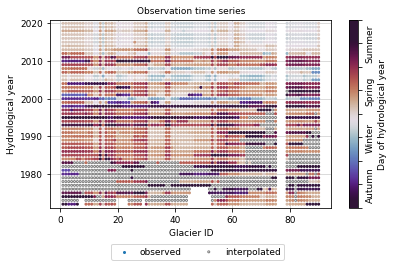

In [6]:
fig, ax = plt.subplots(figsize=(figwidth*2, figwidth*1.1))
gpl.annualObservations(ax, all_glaciers, YEARS, show_firstyear=False, style=style)

plt.savefig('{}fig2_observations.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig2_observations.png'.format(outpath), bbox_inches='tight', dpi=300)


# Figure 3: Box method example
This figure was created in ArcGIS Pro.

# Results: terminus behavior

In [7]:
# -- Identify individual glacier behaviors and calculate basic stats

first_full_year = pd.to_datetime(str(met.firstFullYear(all_glaciers))+'-09')

dominant_length = met.dominantGlaciers(all_glaciers, 'interplengths', \
    startdate=first_full_year)
dominant_area = met.dominantGlaciers(all_glaciers, 'interpareas', \
    startdate=first_full_year)
stable_length = met.stableGlaciers(all_glaciers, 'interplengths', \
    startdate=first_full_year)
stable_area = met.stableGlaciers(all_glaciers, 'interpareas', \
    startdate=first_full_year)
advancing = met.advancingGlaciers(
    all_glaciers, startdate=first_full_year).sort_values().head()
growing = met.growingGlaciers(
    all_glaciers, startdate=first_full_year).sort_values().head()
retreating = met.retreatingGlaciers(
    all_glaciers, startdate=first_full_year).sort_values().head()
shrinking = met.shrinkingGlaciers(
    all_glaciers, startdate=first_full_year).sort_values().head()

glaciers_nondom_length = met.filterGlaciers(all_glaciers, \
    dominant_length.index.values, idtype='remove')
glaciers_nondom_area = met.filterGlaciers(all_glaciers, \
    dominant_area.index.values, idtype='remove')
glaciers_dom_length = met.filterGlaciers(all_glaciers, \
    dominant_length.index.values, idtype='keep')
glaciers_dom_area = met.filterGlaciers(all_glaciers, \
    dominant_area.index.values, idtype='keep')

gid_names_dom_length = [(all_glaciers[g].gid, all_glaciers[g].name) for g in dominant_length.keys()]
gid_names_dom_area = [(all_glaciers[g].gid, all_glaciers[g].name) for g in dominant_area.keys()]
gid_names_stable_length = [(all_glaciers[g].gid, all_glaciers[g].name) for g in stable_length.keys()]
gid_names_stable_area = [(all_glaciers[g].gid, all_glaciers[g].name) for g in stable_area.keys()]
gid_names_advancing = [(all_glaciers[g].gid, all_glaciers[g].name) for g in advancing.keys()]
gid_names_growing = [(all_glaciers[g].gid, all_glaciers[g].name) for g in growing.keys()]
gid_names_retreating = [(all_glaciers[g].gid, all_glaciers[g].name) for g in retreating.keys()]
gid_names_shrinking = [(all_glaciers[g].gid, all_glaciers[g].name) for g in shrinking.keys()]

cumul_area_change = met.finalNetChange(all_glaciers, 'interpareas', startdate=first_full_year).sum()
cumul_length_change = met.finalNetChange(all_glaciers, 'interplengths', startdate=first_full_year).sum()

mean_nondom_area_change = met.finalNetChange(glaciers_nondom_area, 'interpareas', startdate=first_full_year).mean()
mean_nondom_length_change = met.finalNetChange(glaciers_nondom_length, 'interplengths', startdate=first_full_year).mean()

In [8]:
print("Number of terminus positions traced: ", len(termini))
print('Number of images used: ', len(termini.Image_ID.unique()))
print("Number of glaciers: ", len(termini.Glacier_ID.unique()))
print("First date observed: ", termini.Source_Date.min())
print("Last date observed: ", termini.Source_Date.max())
print("Median number of observations per glacier: {:.0f}".format(len(termini)/len(termini.Glacier_ID.unique())))
print("First year of full observations/interpolations: ", first_full_year)
print('Cumulative area change of all glaciers: {:.0f} km2'.format(cumul_area_change))
print('Cumulative length change of all glaciers: {:.0f} km'.format(cumul_length_change))
print('Mean area change of non-dominant glaciers: {:.1f} km2'.format(mean_nondom_area_change))
print('Mean length change of non-dominant glaciers: {:.1f} km'.format(mean_nondom_length_change))

print('\nDominant length glaciers:\n', dominant_length)
print('\n'.join(str(gn) for gn in gid_names_dom_length))
print('\nDominant area glaciers:\n', dominant_area)
print('\n'.join(str(gn) for gn in gid_names_dom_area))
print('\nStable length glaciers:\n', stable_length)
print('\n'.join(str(gn) for gn in gid_names_stable_length))
print('\nStable area glaciers:\n', stable_area)
print('\n'.join(str(gn) for gn in gid_names_stable_area))
print('\nAdvancing glaciers:\n', advancing)
print('\n'.join(str(gn) for gn in gid_names_advancing))
print('\nGrowing glaciers:\n', growing)
print('\n'.join(str(gn) for gn in gid_names_growing))


Number of terminus positions traced:  3606
Number of images used:  455
Number of glaciers:  87
First date observed:  1972-09-16
Last date observed:  2021-03-09
Median number of observations per glacier: 41
First year of full observations/interpolations:  1977-09-01 00:00:00
Cumulative area change of all glaciers: -1067 km2
Cumulative length change of all glaciers: -287 km
Mean area change of non-dominant glaciers: -8.9 km2
Mean length change of non-dominant glaciers: -2.6 km

Dominant length glaciers:
 3    -16.915527
35   -14.648117
36   -11.067766
42   -14.642728
81   -13.991228
dtype: float64
(3, 'Sermeq Kujalleq (Jakobshavn Isbræ)')
(35, 'Nunatakassaap Sermia (Alison Glacier)')
(36, 'Glacier #36')
(42, 'Kjer Gletsjer')
(81, 'Qeqertaarsuusarsuup Sermia (Tracy Gletsjer)')

Dominant area glaciers:
 3    -130.873840
35    -59.442459
42    -81.462135
81    -58.716297
dtype: float64
(3, 'Sermeq Kujalleq (Jakobshavn Isbræ)')
(35, 'Nunatakassaap Sermia (Alison Glacier)')
(42, 'Kjer Gletsje

# Individual Glaciers
Print length and area information about an individual glacier, based on the glacier ID number.


Glacier: #3 (Sermeq Kujalleq (Jakobshavn Isbræ))

Length type: retreating
Cumulative length change since 1977-09-01 00:00:00: -18.3 km
Length variability: 7.39

Area type: shrinking
Cumulative area change since 1977-09-01 00:00:00: -141.8 km2
Area variability: 57.16


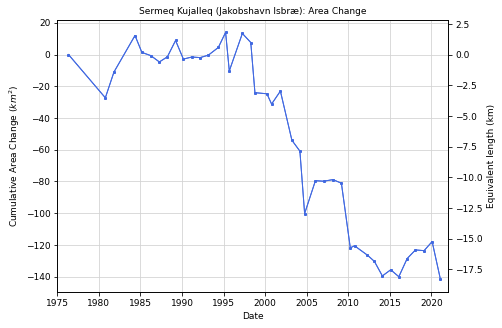

In [9]:
id = 3

length_type = met.lengthType(all_glaciers[id], startdate=first_full_year)
area_type = met.areaType(all_glaciers[id], startdate=first_full_year)
cumul_length_change = all_glaciers[id].cumulativeChange('lengths', startdate=first_full_year)
cumul_area_change = all_glaciers[id].cumulativeChange('areas', startdate=first_full_year)

print('\nGlacier: #{} ({})'.format(id, all_glaciers[id].name))
print('\nLength type: {}'.format(length_type))
print('Cumulative length change since {}: {:.1f} km'.format(first_full_year, cumul_length_change[0].iloc[-1]))
print('Length variability: {:.2f}'.format(cumul_length_change[0].std()))
print('\nArea type: {}'.format(area_type))
print('Cumulative area change since {}: {:.1f} km2'.format(first_full_year, cumul_area_change[0].iloc[-1]))
print('Area variability: {:.2f}'.format(cumul_area_change[0].std()))

fig, ax = plt.subplots(figsize=(7,5))
gpl.cumulativeChange(ax, all_glaciers[id], 'areas', startdate=first_full_year)
ax.set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
ax.set_xticklabels(['1980', '1990', '2000', '2010', '2020'])

axy = ax.twinx()
gpl.cumulativeChange(axy, all_glaciers[id], 'lengths', startdate=first_full_year)
axy.title.set_visible(False)
axy.set_ylabel('Equivalent length (km)')
axy.grid(False)

# Figure 4: Summarized glacier area and length changes
Dominant glacier area (a) and length (b) changes and non-dominant glacier area (c) and length (d).

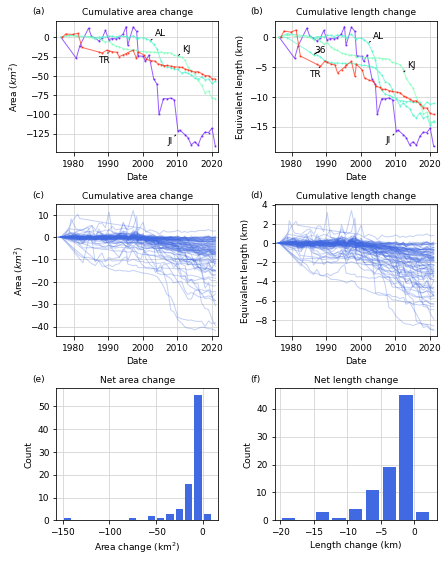

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(figwidth*2, figwidth*2.5)) 
axs = axs.flatten()

# -- Area change - dominant glaciers
gpl.changeSummary(axs[0], glaciers_dom_area, 'areas', GIDS, startdate=first_full_year)
axs[0].annotate(text='(a)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[0].set_xlim(left='1975-01-01', right='2022-01-01')
axs[0].set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[0].set_xticklabels(['1980', '1990', '2000', '2010', '2020'])
axs[0].legend().remove()
axs[0].annotate('JI', xy=('2010-01-01', -125), xytext=(-10, -10), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})
axs[0].annotate('AL', xy=('2002-01-01', -5), xytext=(5, 5), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})
axs[0].annotate('KJ', xy=('2010-01-01', -25), xytext=(5, 5), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})
axs[0].annotate('TR', xy=('1990-01-01', -20), xytext=(-10, -10), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})

# -- Length change - dominant glaciers
gpl.changeSummary(axs[1], glaciers_dom_length, 'lengths', GIDS, startdate=first_full_year)
axs[1].annotate(text='(b)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[1].set_xlim(left='1975-01-01', right='2022-01-01')
axs[1].set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[1].set_xticklabels(['1980', '1990', '2000', '2010', '2020'])
axs[1].set_ylabel('Equivalent length (km)')
axs[1].legend().remove()
axs[1].annotate('JI', xy=('2010-01-01', -16), xytext=(-10, -10), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})
axs[1].annotate('AL', xy=('2002-01-01', -1), xytext=(5, 5), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})
axs[1].annotate('36', xy=('1986-01-01', -3), xytext=(2, 2), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})
axs[1].annotate('KJ', xy=('2012-01-01', -6), xytext=(5, 5), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})
axs[1].annotate('TR', xy=('1988-01-01', -5), xytext=(-10, -10), textcoords='offset points',
    arrowprops={'arrowstyle': '-', 'shrinkA': .5})

# -- Area change - nondominant glaciers
gpl.changeSummary(axs[2], glaciers_nondom_area, 'areas', startdate=first_full_year)
axs[2].annotate(text='(c)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[2].set_xlim(left='1975-01-01', right='2022-01-01')
axs[2].set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[2].set_xticklabels(['1980', '1990', '2000', '2010', '2020'])

# -- Length change - nondominant glaciers
gpl.changeSummary(axs[3], glaciers_nondom_length, 'lengths', startdate=first_full_year)
axs[3].annotate(text='(d)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[3].set_xlim(left='1975-01-01', right='2022-01-01')
axs[3].set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[3].set_xticklabels(['1980', '1990', '2000', '2010', '2020'])
axs[3].set_ylabel('Equivalent length (km)')

# -- Final area change - all glaciers
final_area_changes = np.zeros(len(GIDS))
for n in np.arange(len(GIDS)):
    gid = GIDS[n]
    final_area_change = all_glaciers[gid].cumulativeChange('areas', startdate=first_full_year)[0].iloc[-1]
    final_area_changes[n] = final_area_change
axs[4].annotate(text='(e)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[4].hist(final_area_changes, bins=np.arange(-150,20,10), rwidth=0.8, color='royalblue')
axs[4].set_title('Net area change')
axs[4].set_xlabel('Area change (km$^2$)')
axs[4].set_ylabel('Count')

# -- Final length change - all glaciers
final_length_changes = np.zeros(len(GIDS))
for n in np.arange(len(GIDS)):
    gid = GIDS[n]
    final_length_change = all_glaciers[gid].cumulativeChange('lengths', startdate=first_full_year)[0].iloc[-1]
    final_length_changes[n] = final_length_change
axs[5].annotate(text='(f)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[5].hist(final_length_changes, bins=np.arange(-20,5,2.5), rwidth=0.8, color='royalblue')
axs[5].set_title('Net length change')
axs[5].set_xlabel('Length change (km)')
axs[5].set_ylabel('Count')

plt.tight_layout()

plt.savefig('{}fig4_changes.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig4_changes.png'.format(outpath), bbox_inches='tight', dpi=300)


# Figure 5:
Normalized glacier area (a) and length (b) changes shown in gray, with mean and standard deviation overlain in blue. Histograms of the years in which change points occur in area (c) and length (d) trends for each glacier.

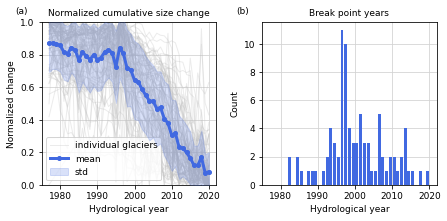

In [11]:
n_segs = 2

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(figwidth*2, figwidth))
axs = axs.flatten()

# -- Normalized area (and length) change
gpl.changeSummaryNorm(axs[0], all_glaciers, 'interpareas', startdate=first_full_year, showmean=True)
axs[0].annotate(text='(a)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[0].set_xlim(left='1975-01-01', right='2022-01-01')
axs[0].set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[0].set_xticklabels(['1980', '1990', '2000', '2010', '2020'])
axs[0].set_title('Normalized cumulative size change')
axs[0].set_xlabel('Hydrological year')
# axs[0].legend().remove()

# -- Area (and length) change breakpoints
gpl.breakPointsHist(axs[1], all_glaciers, 'interpareas', time_bins=YEARS, n_segs=n_segs, startdate=first_full_year)
axs[1].annotate(text='(b)', xy=(-0.15, 1.05), xycoords='axes fraction')
axs[1].set_xlim(left='1975-01-01', right='2022-01-01')
axs[1].set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[1].set_xticklabels(['1980', '1990', '2000', '2010', '2020'])
axs[1].set_title('Break point years')
axs[1].set_xlabel('Hydrological year')

# fig.legend(handles=axs[0].get_legend_handles_labels()[0][-3:], loc='lower left', bbox_to_anchor=(0.25, -0.25))

plt.tight_layout()

plt.savefig('{}fig5_breakpoints.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig5_breakpoints.png'.format(outpath), bbox_inches='tight', dpi=300)


Text(0, 0.5, 'Count')

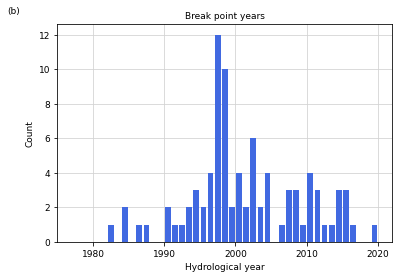

In [12]:
# Testing breakpoints with only observed areas instead of interpolated areas

fig, ax = plt.subplots()

time_bins = pd.to_datetime(YEARS, format='%Y')
all_breaks = []
for g in all_glaciers:
    glacier = all_glaciers[g]
    attrs, dates = glacier.filterDates('areas', startdate=first_full_year, enddate=None)
    attrs = attrs[~np.isnan(attrs)]
    dates = [d.year for d in pd.to_datetime(dates)]
    attrs = attrs.values
    pwlf_fun = pwlf.PiecewiseLinFit(dates, attrs)
    breaks = pwlf_fun.fit(n_segs)
    breaks = [y for y in breaks if y != dates[0]]
    breaks = [y for y in breaks if y != dates[-1]]
    breaks = [round(y) for y in breaks]
    all_breaks.extend(pd.to_datetime(breaks, format='%Y'))
all_breaks
graph = ax.hist(all_breaks, bins=time_bins, align='mid', rwidth=0.8, color=gpl.getColor('default'))
ax.annotate(text='(b)', xy=(-0.15, 1.05), xycoords='axes fraction')
ax.set_xlim(left='1975-01-01', right='2022-01-01')
ax.set_xticks(['1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
ax.set_xticklabels(['1980', '1990', '2000', '2010', '2020'])
ax.set_title('Break point years')
ax.set_xlabel('Hydrological year')
ax.set_ylabel('Count')

In [13]:
n_segs = 2

norm_mean_area, norm_std_area = met.normChangeStats(all_glaciers, 'interpareas', startdate=first_full_year)
norm_mean_area = norm_mean_area[~np.isnan(norm_mean_area)]
norm_mean_area_dates = norm_mean_area.index.values
pwlf_fun_area = pwlf.PiecewiseLinFit(norm_mean_area_dates, norm_mean_area.values)
breaks_area = pwlf_fun_area.fit(n_segs)
breaks_area = [y for y in breaks_area if y != norm_mean_area_dates[0]]
breaks_area = [y for y in breaks_area if y != norm_mean_area_dates[-1]]
breaks_area = [round(y) for y in breaks_area]
area_fit = pwlf_fun_area.predict(YEARS)
area_rates = np.diff(area_fit) / np.diff(YEARS)

# norm_mean_length, norm_std_length = met.normChangeStats(all_glaciers, 'interplengths', startdate=first_full_year)
# norm_mean_length = norm_mean_length[~np.isnan(norm_mean_length)]
# norm_mean_length_dates = norm_mean_length.index.values
# pwlf_fun_length = pwlf.PiecewiseLinFit(norm_mean_length_dates, norm_mean_length.values)
# breaks_length = pwlf_fun_length.fit(n_segs)
# breaks_length = [y for y in breaks_length if y != norm_mean_length_dates[0]]
# breaks_length = [y for y in breaks_length if y != norm_mean_length_dates[-1]]
# breaks_length = [round(y) for y in breaks_length]
# length_fit = pwlf_fun_length.predict(YEARS)
# length_rates = np.diff(length_fit) / np.diff(YEARS)

print('Prior to {}, mean area (and length) change was {:.1f}% per decade.'.format(breaks_area, 10*100*area_rates[0]))
print('After {}, mean area (and length) change was {:.1f}% per decade.'.format(breaks_area, 10*100*area_rates[-1]))
print('This represents a {:.1f}x change in rate.'.format(area_rates[-1]/area_rates[0]))
# print('\nPrior to {}, mean length change was {:.1f}% per decade.'.format(breaks_length, 10*100*length_rates[0]))
# print('After {}, mean length change was {:.1f}% per decade.'.format(breaks_length, 10*100*length_rates[-1]))
# print('This represents a {:.1f}x change in rate.'.format(length_rates[-1]/length_rates[0]))


Prior to [1996], mean area (and length) change was -3.8% per decade.
After [1996], mean area (and length) change was -31.4% per decade.
This represents a 8.3x change in rate.


# Supplementary Table 2
Change GID and run to print values for each glacier ID in the table.

In [14]:
gid = 90

significant_area = met.significantChange(all_glaciers, 'interpareas', startdate=first_full_year)
significant_length = met.significantChange(all_glaciers, 'interplengths', startdate=first_full_year)

print('Glacier ID: {}\n'.format(gid))
print('Observations: {}'.format(len(all_glaciers[gid].obsseries)))
print('Net area change: {:.2f}'.format(all_glaciers[gid].areas.diff().cumsum().iloc[-1]))
print('Area change is significant? {}'.format(significant_area.loc[gid]))
print('Net length change: {:.2f}'.format(all_glaciers[gid].lengths.diff().cumsum().iloc[-1]))
print('Length change is significant? {}'.format(significant_length.loc[gid]))
print('Breakpoint: {}'.format(met.getBreakPoints(all_glaciers[gid], 'interpareas', n_segs=2, startdate=first_full_year)[0][0]))


Glacier ID: 90

Observations: 42
Net area change: -1.27
Area change is significant? True
Net length change: -0.80
Length change is significant? True
Breakpoint: 1997


# Figure 6: MAR ice sheet climate variables

In [15]:
# Load MAR data and resample, subset

mar_data = clm.loadData(mar_dir, dtype='mar')
mar = mar_data.resample(TIME='AS', keep_attrs=True).mean()
mar = clm.subsetGeographic(mar, ice_bounds, dtype='mar')
mar = clm.subsetIce(mar, threshold=ice_minimum)
mar = clm.subsetTopography(mar, topo_range, dtype='mar')

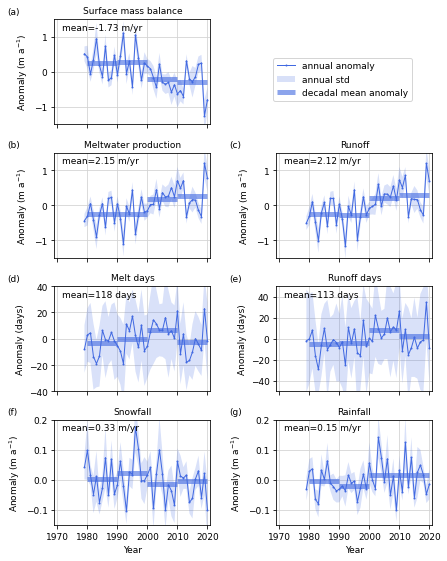

In [16]:
# Plot annual and decadal MAR variables averaged across glacier coordinates

# -- PORTRAIT ORIENTATION
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(figwidth*2, figwidth*2.5))
axs = axs.flatten()

# -- Surface mass balance
mar.SMB.load()
cpl.marAnomalyBulk(axs[0], mar, glacier_coords, 'SMB', ann_mean=True, error=True, dec_mean=True)
axs[0].set_ylim(bottom=-1.5, top=1.5)
axs[0].xaxis.label.set_visible(False)
axs[0].annotate(text='(a)', xy=(-0.3, 1.05), xycoords='axes fraction')

# -- Meltwater production
mar.ME.load()
cpl.marAnomalyBulk(axs[2], mar, glacier_coords, 'ME', ann_mean=True, error=True, dec_mean=True)
axs[2].set_ylim(bottom=-1.5, top=1.5)
axs[2].xaxis.label.set_visible(False)
axs[2].annotate(text='(b)', xy=(-0.3, 1.05), xycoords='axes fraction')

# -- Runoff
mar.RU.load()
cpl.marAnomalyBulk(axs[3], mar, glacier_coords, 'RU', ann_mean=True, error=True, dec_mean=True)
axs[3].set_ylim(bottom=-1.5, top=1.5)
axs[3].xaxis.label.set_visible(False)
axs[3].annotate(text='(c)', xy=(-0.3, 1.05), xycoords='axes fraction')

# -- Number of melt days
ig, er, am, dm, dec_mean_medays = cpl.marMeltDaysAnomaly(axs[4], mar_data, glacier_coords, ann_mean=True, error=True, dec_mean=True)
axs[4].set_ylim(bottom=-40, top=40)
axs[4].xaxis.label.set_visible(False)
axs[4].annotate(text='(d)', xy=(-0.3, 1.05), xycoords='axes fraction')

# -- Number of runoff days
ig, er, am, dm, dec_mean_rudays = cpl.marRunoffDaysAnomaly(axs[5], mar_data, glacier_coords, ann_mean=True, error=True, dec_mean=True)
axs[5].set_ylim(bottom=-50, top=50)
axs[5].xaxis.label.set_visible(False)
axs[5].annotate(text='(e)', xy=(-0.3, 1.05), xycoords='axes fraction')

# -- Snowfall
mar.SF.load()
cpl.marAnomalyBulk(axs[6], mar, glacier_coords, 'SF', ann_mean=True, error=True, dec_mean=True)
axs[6].set_ylim(bottom=-.15, top=.2)
axs[6].annotate(text='(f)', xy=(-0.3, 1.05), xycoords='axes fraction')
axs[6].set_xlim(left='1969-01-01', right='2021-01-01')
axs[6].set_xticks(['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[6].set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])

# -- Rainfall
mar.RF.load()
cpl.marAnomalyBulk(axs[7], mar, glacier_coords, 'RF', ann_mean=True, error=True, dec_mean=True)
axs[7].set_ylim(bottom=-.15, top=.2)
axs[7].annotate(text='(g)', xy=(-0.3, 1.05), xycoords='axes fraction')
axs[7].set_xlim(left='1969-01-01', right='2021-01-01')
axs[7].set_xticks(['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
axs[7].set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])

# -- Put legend in axs[1] location and turn off axis
fig.legend(handles=axs[7].get_legend_handles_labels()[0][-3:], ncol=1, loc='upper left', bbox_to_anchor=(0.6, 0.9))
axs[1].axis('off')
plt.tight_layout()
plt.savefig('{}fig6_mar.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig6_mar.png'.format(outpath), bbox_inches='tight', dpi=300)


# -- LANDSCAPE ORIENTATION
# fig, axs = plt.subplots(
#     nrows=2, ncols=4, 
#     sharex=True, sharey=False, 
#     figsize=(figwidth*4, figwidth*1.5))
# axs = axs.flatten()

# mar.SMB.load()
# ig, er, am, dm = cpl.marAnomalyBulk(axs[0], mar, glacier_coords, 'SMB', ann_mean=True, error=True, dec_mean=True, style=style)
# axs[0].set_ylim(bottom=-1.5, top=1.5)
# axs[0].xaxis.label.set_visible(False)
# axs[0].annotate(text='(a)', xy=(-0.3, 1.05), xycoords='axes fraction')

# ig, er, am, dm = cpl.marAnomalyBulk(axs[1], mar, glacier_coords, 'ME', ann_mean=True, error=True, dec_mean=True, style=style)
# axs[1].set_ylim(bottom=-1.5, top=1.5)
# axs[1].xaxis.label.set_visible(False)
# axs[1].annotate(text='(b)', xy=(-0.3, 1.05), xycoords='axes fraction')

# ig, er, am, dm, dec_mean_medays = cpl.marMeltDaysAnomaly(axs[5], mar_data, glacier_coords, ann_mean=True, error=True, dec_mean=True, style=style)
# axs[5].set_ylim(bottom=-40, top=40)
# axs[5].annotate(text='(c)', xy=(-0.3, 1.05), xycoords='axes fraction')

# ig, er, am, dm = cpl.marAnomalyBulk(axs[2], mar, glacier_coords, 'RU', ann_mean=True, error=True, dec_mean=True, style=style)
# axs[2].set_ylim(bottom=-1.5, top=1.5)
# axs[2].xaxis.label.set_visible(False)
# axs[2].annotate(text='(d)', xy=(-0.3, 1.05), xycoords='axes fraction')

# ig, er, am, dm, dec_mean_rudays = cpl.marRunoffDaysAnomaly(axs[6], mar_data, glacier_coords, ann_mean=True, error=True, dec_mean=True, style=style)
# axs[6].set_ylim(bottom=-50, top=50)
# axs[6].annotate(text='(e)', xy=(-0.3, 1.05), xycoords='axes fraction')

# ig, er, am, dm = cpl.marAnomalyBulk(axs[3], mar, glacier_coords, 'SF', ann_mean=True, error=True, dec_mean=True, style=style)
# axs[3].set_ylim(bottom=-.15, top=.2)
# axs[3].annotate(text='(f)', xy=(-0.3, 1.05), xycoords='axes fraction')
# axs[3].set_xlim(left='1969-01-01', right='2021-01-01')
# axs[3].xaxis.label.set_visible(False)
# axs[3].set_xticks(['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
# axs[3].set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])

# mar.RF.load()
# ig, er, am, dm = cpl.marAnomalyBulk(axs[7], mar, glacier_coords, 'RF', ann_mean=True, error=True, dec_mean=True, style=style)
# axs[7].set_ylim(bottom=-.15, top=.2)
# axs[7].annotate(text='(g)', xy=(-0.3, 1.05), xycoords='axes fraction')
# axs[7].set_xlim(left='1969-01-01', right='2021-01-01')
# axs[7].set_xticks(['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
# axs[7].set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])

# fig.legend(handles=[am, er, dm], ncol=1, loc='upper left', bbox_to_anchor=(0.05, 0.4))
# axs[4].axis('off')
# plt.tight_layout()




## Values for Fig. 6

Calculate bulk anomaly (across several glacier coordinates) and decadal mean anomaly for MAR data.

For dvar, choose from:
- 'SMB' (surface mass balance)
- 'ME' (meltwater production)
- 'RU' (runoff)
- 'SF' (snowfall)
- 'RF' (rainfall)

In [17]:
dvar = 'ME'

mar[dvar].load()
bulk_mean = clm.bulkMeanMAR(mar, glacier_coords, dvar)
bulk_anom = clm.bulkAnomalyMAR(mar, glacier_coords, dvar)
dec_anom = clm.decadalAnomalyMAR(mar, glacier_coords, dvar)

dec_anom

1980-01-01   -0.250823
1990-01-01   -0.235332
2000-01-01    0.185555
2010-01-01    0.267516
2020-01-01    0.765108
Freq: 10AS-JAN, dtype: float64

In [18]:
start_decade = '1990-01-01'
end_decade = '2000-01-01'

abs_change = dec_anom[end_decade] - dec_anom[start_decade]

dec_mean = dec_anom + bulk_mean
pct_change = 100 * (dec_mean[end_decade] - dec_mean[start_decade]) / dec_mean[start_decade]

print('Absolute change in {} between {} and {}: {:.3f} m'.format(dvar, start_decade, end_decade, abs_change))
print('Percent change in {} between {} and {}: {:.0f}%'.format(dvar, start_decade, end_decade, pct_change))

Absolute change in ME between 1990-01-01 and 2000-01-01: 0.421 m
Percent change in ME between 1990-01-01 and 2000-01-01: 22%


In [19]:
start_decade = '2000-01-01'
end_decade = '2010-01-01'

mean_rudays = dec_mean_rudays + 113

abs_change = mean_rudays[end_decade] - mean_rudays[start_decade]
pct_change = 100 * (mean_rudays[end_decade] - mean_rudays[start_decade]) / mean_rudays[start_decade]

print('Absolute change in RU days between {} and {}: {:.0f}'.format(start_decade, end_decade, abs_change))
print('Percent change in RU days between {} and {}: {:.0f}%'.format(start_decade, end_decade, pct_change))

Absolute change in RU days between 2000-01-01 and 2010-01-01: -6
Percent change in RU days between 2000-01-01 and 2010-01-01: -5%


# Ocean data

In [3]:
# Load Ocean Temperature Data

# -- ECCO
ecco_sst = clm.loadData(ecco_sst_dir, dtype='ecco5')
ecco_sst = clm.subsetGeographic(ecco_sst, ocean_bounds, dtype='ecco5')
ecco_sst = clm.subsetTime(ecco_sst, times, dtype='ecco5')
ecco_sst = ecco_sst.resample(time='AS', keep_attrs=True).mean()
ecco_sst = clm.eccoTemperature(ecco_sst, dtype='ecco5')
ecco_sst.temperature.load()

# -- ICES-DK
icesdk_data = clm.loadData(icesdk_file, dtype='icesdk')
icesdk_data = clm.subsetGeographic(icesdk_data, ocean_bounds, dtype='icesdk')
icesdk_data = clm.subsetTime(icesdk_data, times, dtype='icesdk')

# -- Hadley-OI
hadley_sst = clm.loadData(hadley_sst_dir, dtype='hadley')
hadley_sst = clm.subsetGeographic(hadley_sst, ocean_bounds, dtype='hadley')
hadley_sst = clm.subsetTime(hadley_sst, times, dtype='hadley')
hadley_sst = hadley_sst.resample(time='AS', keep_attrs=True).mean()
hadley_sst.SST.load()

<xarray.DataArray 'SST' (time: 49, lat: 14, lon: 36)>
array([[[-0.7196666 , -1.0884166 , -1.0884166 , ...,  0.99026924,
          0.99456406,  0.9988589 ],
        [-1.0535833 , -1.0535833 , -1.0535833 , ...,  0.94880563,
          0.9461898 ,  0.9435741 ],
        [-1.0535833 , -0.18483329, -0.18483329, ...,  0.655119  ,
          0.60355556,  0.551992  ],
        ...,
        [-1.53725   , -1.53725   , -1.53725   , ..., -1.2645624 ,
         -1.2753565 , -1.2861509 ],
        [-1.53725   , -1.53725   , -1.53725   , ..., -1.5934908 ,
         -1.5956621 , -1.5978334 ],
        [-1.7149167 , -1.6936457 , -1.672375  , ..., -1.8       ,
         -1.8       , -1.8       ]],

       [[-0.7132222 , -0.7272222 , -0.7272222 , ...,  0.07889313,
         -0.06153205, -0.20195724],
        [-0.53522223, -0.53522223, -0.53522223, ...,  0.3336574 ,
          0.2356929 ,  0.13772841],
        [-0.53522223, -0.49272218, -0.49272218, ...,  0.41740477,
          0.3333982 ,  0.24939156],
...
        [-0.8980953 , -0.8980953 , -0.81619215, ..., -1.0517645 ,
         -1.0632617 , -1.0747589 ],
        [-0.8980953 , -0.8980953 , -0.81619215, ...,  1.8829206 ,
          2.0537739 ,  2.2246273 ],
        [-1.3297945 , -1.0946919 , -0.8595893 , ..., -0.5169094 ,
         -0.17463975,  0.16762985]],

       [[-0.4730475 , -0.5118421 , -0.5027523 , ...,  1.5408759 ,
          1.4433208 ,  1.3457656 ],
        [-0.17918305, -0.17918305, -0.17918305, ...,  1.3322465 ,
          1.2174034 ,  1.10256   ],
        [-0.87032264, -0.87032264,  0.14529306, ...,  1.2052416 ,
          1.096855  ,  0.98846877],
        ...,
        [-0.7219589 , -0.7219589 , -0.6917866 , ..., -1.1065177 ,
         -1.1211613 , -1.1358047 ],
        [-0.7219589 , -0.7219589 , -0.6917866 , ...,  2.0968518 ,
          2.2687497 ,  2.4406474 ],
        [-0.90854967, -0.9861912 , -1.063833  , ..., -0.22239037,
          0.11516744,  0.45272523]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1972-01-01 1973-01-01 ... 2020-01-01
  * lon      (lon) float32 284.5 285.5 286.5 287.5 ... 316.5 317.5 318.5 319.5
  * lat      (lat) float32 68.5 69.5 70.5 71.5 72.5 ... 77.5 78.5 79.5 80.5 81.5

# Figure 7: Ocean subsurface temperatures

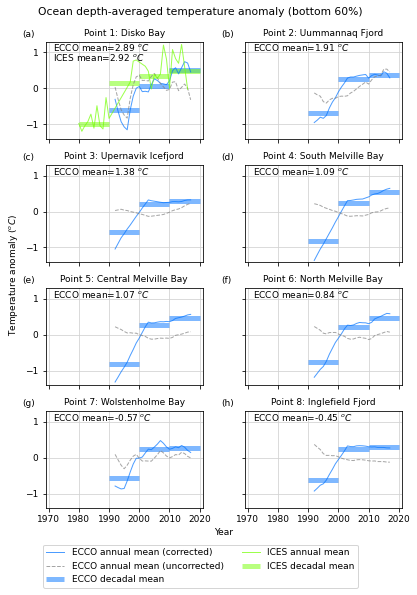

In [4]:
# Plot ocean temperature at specified depth at each point

# Load Wood et al (2021) data for comparison/corrections
wood_data = pd.read_csv('./wood2021_subset.csv')
wood_data = wood_data.iloc[0:6]
wood_data.set_index('Unnamed: 0', inplace=True)
wood_data.iloc[2:] = wood_data.iloc[2:].astype('float')

cw1 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'CW1']
cw2 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'CW2']
nw1 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW1']
nw2 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW2']
nw3 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW3']
nw4 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW4']
n1 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'N1']
wood_pieces = [cw2, cw1, nw4, nw3, nw2, nw1, n1, n1]

cw1_dw = cw1.loc[:, cw1.loc['Categorization'] == 'DW']
cw2_dw = cw2.loc[:, cw2.loc['Categorization'] == 'DW']
nw1_dw = nw1.loc[:, nw1.loc['Categorization'] == 'DW']
nw2_dw = nw2.loc[:, nw2.loc['Categorization'] == 'DW']
nw3_dw = nw3.loc[:, nw3.loc['Categorization'] == 'DW']
nw4_dw = nw4.loc[:, nw4.loc['Categorization'] == 'DW']
n1_dw = n1.loc[:, n1.loc['Categorization'] == 'DW']
wood_pieces_dw = [cw2_dw, cw1_dw, nw4_dw, nw3_dw, nw2_dw, nw1_dw, n1_dw, n1_dw]

fig, axs = plt.subplots(
    nrows=4, ncols=2, 
    sharex=True, sharey=True, 
    figsize=(figwidth*2, figwidth*2.5))
# fig, axs = plt.subplots(
#     nrows=2, ncols=4, 
#     sharex=True, sharey=True, 
#     figsize=(figwidth*4, figwidth*1.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

ecco_decadal = pd.DataFrame(index=['1990', '2000', '2010'],
                            columns=['0', '1', '2', '3', '4', '5', '6', '7'])
ices_decadal = pd.DataFrame(index=['1980', '1990', '2000', '2010'],
                            columns=['0'])

for coordinate in ocean_points:
    idx = ocean_points.index(coordinate)
    nax = axs[idx]
    wood_piece = wood_pieces_dw[idx]
    if idx == 0:
        eagc, eagu, edg, iag, idg, ecco_decade, ices_decade = cpl.subSurfaceTemperatureAnomaly(
            nax, depth=ocean_depth, idx=idx, coordinate=coordinate, 
            ecco=ecco_sst, ecco_dtype='ecco5', icesdk=icesdk_data, wood_data=wood_piece,
            dec_mean=True, spgrid=True, style=style)
        ices_decadal[str(idx)] = ices_decade.anomaly.values
    else:
        _, _, _, _, _, ecco_decade, _ = cpl.subSurfaceTemperatureAnomaly(
            nax, depth=ocean_depth, idx=idx, coordinate=coordinate, 
            ecco=ecco_sst, ecco_dtype='ecco5', wood_data=wood_piece,
            dec_mean=True, spgrid=True, style=style)
    ecco_decadal[str(idx)] = ecco_decade.values
    nax.set_title('Point {}: {}'.format(idx+1, ocean_point_names[idx]))
    nax.set_ylim(bottom=-1.4, top=1.3)
    nax.set_xlim(left='1969-01-01', right='2021-01-01')
    nax.set_xticks(
        ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
    nax.set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])
    label = labels[idx]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')

cpl.subplotGridLabels(
    fig, 
    title='Ocean depth-averaged temperature anomaly (bottom 60%)', 
    ylabel='Temperature anomaly ($^oC$)', 
    xlabel='Year')

# -- add legend for whole figure
fig.legend(handles=[eagc, eagu, edg, iag, idg], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))

plt.tight_layout()

plt.savefig('{}fig7_subsurfacetemp.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig7_subsurfacetemp.png'.format(outpath), bbox_inches='tight', dpi=300)


In [17]:
print('Difference (*C) between 1990 and 2000 for ECCO:')
print(ecco_decadal.loc['2000'] - ecco_decadal.loc['1990'])
print('Mean difference (*C) between 1990 and 2000 for ECCO:')
print((ecco_decadal.loc['2000'] - ecco_decadal.loc['1990']).mean())
print('\nDifference (*C) between 2000 and 2010 for ECCO:')
print(ecco_decadal.loc['2010'] - ecco_decadal.loc['2000'])
ecco_decadal

Difference (*C) between 1990 and 2000 for ECCO:
0    0.688821
1    0.925477
2    0.789680
3    1.064768
4    1.067972
5    0.969419
6    0.819484
7    0.854617
dtype: float64
Mean difference (*C) between 1990 and 2000 for ECCO:
0.8975297174158667

Difference (*C) between 2000 and 2010 for ECCO:
0    0.445812
1    0.118357
2    0.066625
3    0.295717
4    0.211592
5    0.255924
6    0.011595
7    0.041346
dtype: float64


,0,1,2,3,4,5,6,7
1990,-0.614049,-0.677133,-0.567201,-0.828137,-0.804470,-0.749882,-0.570903,-0.604380
2000,0.074772,0.248345,0.222478,0.236631,0.263501,0.219537,0.248581,0.250237
2010,0.520584,0.366702,0.289103,0.532348,0.475094,0.475461,0.260176,0.291584


In [18]:
print('Difference (*C) between 2000 and 1990 for ICES:')
print(ices_decadal.loc['2000'] - ices_decadal.loc['1990'])
ices_decadal

Difference (*C) between 2000 and 1990 for ICES:
0    0.208834
dtype: float64


,0
1980,-0.980185
1990,0.143959
2000,0.352794
2010,0.483432


# Figure 8: Sea surface temperature

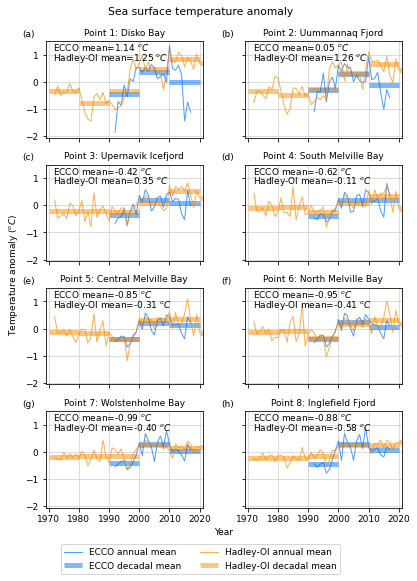

In [19]:
# Plot sea surface temperature at each point
fig, axs = plt.subplots(
    nrows=4, ncols=2, 
    sharex=True, sharey=True, 
    figsize=(figwidth*2, figwidth*2.5))
# fig, axs = plt.subplots(
#     nrows=2, ncols=4, 
#     sharex=True, sharey=True, 
#     figsize=(figwidth*4, figwidth*1.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

ecco_decadal = pd.DataFrame(index=['1990', '2000', '2010'],
                            columns=['0', '1', '2', '3', '4', '5', '6', '7'])
hadley_decadal = pd.DataFrame(index=['1970', '1980', '1990', '2000', '2010', '2020'],
                            columns=['0', '1', '2', '3', '4', '5', '6', '7'])

for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    eag, edg, hag, hdg, ecco_decade, hadley_decade = cpl.seaSurfaceTemperatureAnomaly(
        nax, coordinate=coordinate, 
        ecco=ecco_sst, ecco_dtype='ecco5', hadley=hadley_sst, 
        dec_mean=True, spgrid=True, style=style)
    ecco_decadal[str(ocean_points.index(coordinate))] = ecco_decade.values
    hadley_decadal[str(ocean_points.index(coordinate))] = hadley_decade.values
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1, 
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_ylim(bottom=-2.05, top=1.5)
    nax.set_xlim(left='1969-01-01', right='2021-01-01')
    nax.set_xticks(
        ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
    nax.set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')

cpl.subplotGridLabels(
    fig, 
    title='Sea surface temperature anomaly', 
    ylabel='Temperature anomaly ($^oC$)', 
    xlabel='Year')

# -- add legend for whole figure
fig.legend(handles=[eag, edg, hag, hdg], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))

plt.tight_layout()

plt.savefig('{}fig8_seasurfacetemp.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig8_seasurfacetemp.png'.format(outpath), bbox_inches='tight', dpi=300)


In [20]:
print('Difference (*C) between 1990 and 2000 for ECCO:')
print(ecco_decadal.loc['2000'] - ecco_decadal.loc['1990'])
print('Mean difference (*C) between 1990 and 2000 for ECCO:')
print((ecco_decadal.loc['2000'] - ecco_decadal.loc['1990']).mean())
print('\nDifference (*C) between 2000 and 2010 for ECCO:')
print(ecco_decadal.loc['2010'] - ecco_decadal.loc['2000'])
ecco_decadal

Difference (*C) between 1990 and 2000 for ECCO:
0    0.784585
1    0.584774
2    0.571015
3    0.582677
4    0.613944
5    0.625013
6    0.723691
7    0.739504
dtype: float64
Mean difference (*C) between 1990 and 2000 for ECCO:
0.6531503437593863

Difference (*C) between 2000 and 2010 for ECCO:
0   -0.372886
1   -0.400974
2   -0.112561
3    0.005886
4   -0.105221
5   -0.168388
6   -0.258611
7   -0.247277
dtype: float64


,0,1,2,3,4,5,6,7
1990,-0.428440,-0.281467,-0.360684,-0.405203,-0.392662,-0.380890,-0.421444,-0.435879
2000,0.356145,0.303307,0.210331,0.177474,0.221281,0.244123,0.302247,0.303625
2010,-0.016741,-0.097667,0.097770,0.183361,0.116061,0.075735,0.043636,0.056348


In [21]:
print('Difference (*C) between 1990 and 2000 for Hadley-OI:')
print(hadley_decadal.loc['2000'] - hadley_decadal.loc['1990'])
print('Mean difference (*C) between 1990 and 2000 for Hadley-OI:')
print((hadley_decadal.loc['2000'] - hadley_decadal.loc['1990']).mean())
print('\nDifference (*C) between 2000 and 2010 for Hadley-OI:')
print(hadley_decadal.loc['2010'] - hadley_decadal.loc['2000'])
hadley_decadal

Difference (*C) between 1990 and 2000 for Hadley-OI:
0    0.812758
1    0.585066
2    0.331810
3    0.336944
4    0.699612
5    0.530000
6    0.393748
7    0.382998
dtype: float32
Mean difference (*C) between 1990 and 2000 for Hadley-OI:
0.5091171

Difference (*C) between 2000 and 2010 for Hadley-OI:
0    0.385371
1    0.316409
2    0.435608
3    0.279323
4    0.071084
5    0.127043
6   -0.112649
7   -0.005917
dtype: float32


,0,1,2,3,4,5,6,7
1970,-0.330651,-0.349290,-0.227154,-0.093151,-0.125909,-0.116118,-0.170592,-0.218714
1980,-0.760988,-0.477587,-0.212888,-0.081366,-0.149000,-0.071808,-0.138068,-0.216655
1990,-0.351334,-0.258044,-0.244116,-0.261763,-0.401911,-0.345895,-0.139347,-0.134458
2000,0.461424,0.327022,0.087694,0.075180,0.297701,0.184106,0.254402,0.248541
2010,0.846796,0.643430,0.523302,0.354503,0.368785,0.311148,0.141752,0.242623
2020,0.686231,0.446117,0.277304,-0.120329,-0.148475,0.153433,0.177339,0.349200


In [22]:
# Load Sea Ice Concentration Data

# -- Hadley-OI
hadley_sic = clm.loadData(hadley_sic_dir, dtype='hadley')
hadley_sic = clm.subsetGeographic(hadley_sic, ocean_bounds, dtype='hadley')
hadley_sic = clm.subsetTime(hadley_sic, times, dtype='hadley')
hadley_sic.SEAICE.load()

# -- NOAA
noaa_sic = clm.loadData(noaa_sic_dir, dtype='noaa')
noaa_sic = clm.subsetGeographic(noaa_sic, ocean_bounds, 'noaa')
noaa_sic = clm.subsetTime(noaa_sic, times, dtype='noaa')
noaa_sic[noaa_var].load()

<xarray.DataArray 'goddard_merged_seaice_conc_monthly' (time: 493, ygrid: 66, xgrid: 58)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2019-12-01
  * ygrid      (ygrid) float32 -7.625e+05 -7.875e+05 ... -2.362e+06 -2.388e+06
  * xgrid      (xgrid) float32 -1.238e+06 -1.212e+06 ... 1.625e+05 1.875e+05
    latitude   (ygrid, xgrid) float64 76.64 76.83 77.03 ... 68.18 68.17 68.15
    longitude  (ygrid, xgrid) float64 -103.4 -102.8 -102.3 ... -41.11 -40.51
Attributes:
    valid_range:    [  0 100]
    long_name:      Goddard Edited Climate Data Record of Passive Microwave M...
    standard_name:  sea_ice_area_fraction
    units:          1
    flag_values:    [-5 -4 -3 -2 -1]
    flag_meanings:  pole_hole lakes coastal land_mask missing_data
    datum:          +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:   projection
    reference:      http://nsidc.org/data/nsidc-0051.html http://nsidc.org/da...

# Figure 9: Sea ice season length

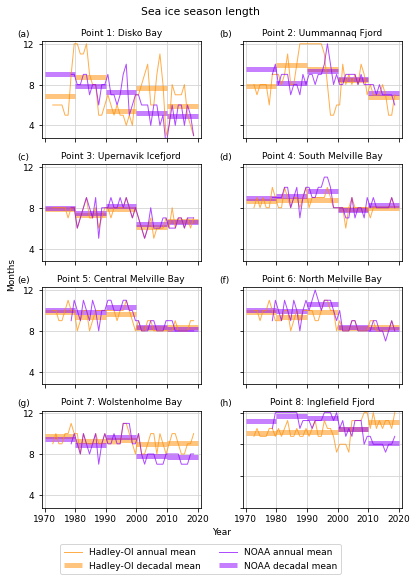

In [23]:
# Get length of sea ice season at each point

fig, axs = plt.subplots(
    nrows=4, ncols=2, 
    sharex=True, sharey=True, 
    figsize=(figwidth*2, figwidth*2.5))
# fig, axs = plt.subplots(
#     nrows=2, ncols=4, 
#     sharex=True, sharey=True, 
#     figsize=(figwidth*4, figwidth*1.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for coordinate in ocean_points:
    # Determine ice season length
    nax = axs[ocean_points.index(coordinate)]
    _, hag, hdg, nag, ndg = cpl.seaIceSeasonLength(
        nax, coordinate, sic_minimum, 
        hadley=hadley_sic, noaa=noaa_sic, noaa_var=noaa_var, 
        dec_mean=True, spgrid=True, style=style)
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1, 
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_ylim(bottom=2.75, top=12.25)
    nax.set_xlim(left='1969-01-01', right='2021-01-01')
    nax.set_xticks(
        ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
    nax.set_yticks([0,4,8,12])
    nax.set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')
    
cpl.subplotGridLabels(
    fig, 
    title='Sea ice season length', 
    xlabel='Year', 
    ylabel='Months')

# -- add legend for whole figure
fig.legend(handles=[hag, hdg, nag, ndg], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))

plt.tight_layout()

plt.savefig('{}fig9_seaiceseasonlength.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}fig9_seaiceseasonlength.png'.format(outpath), bbox_inches='tight', dpi=300)


# Supplementary Figures: Seasonal sea ice concentration

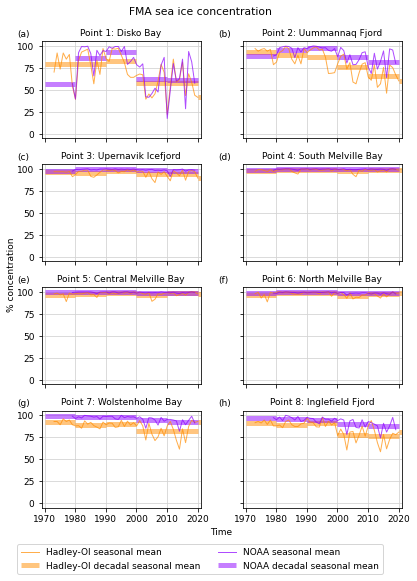

In [24]:
# Plot seasonal sea ice concentration at each point

fig, axs = plt.subplots(
    nrows=4, ncols=2, 
    sharex=True, sharey=True, 
    figsize=(figwidth*2, figwidth*2.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    _, hag, hdg, nag, ndg = cpl.seaIceConcentration(
        nax, coordinate=coordinate, season_start=2, 
        hadley=hadley_sic, noaa=noaa_sic, noaa_var=noaa_var, 
        dec_mean=True, spgrid=True, style=style)
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1, 
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_ylim(bottom=-5, top=105)
    nax.set_xlim(left='1969-01-01', right='2021-01-01')
    nax.set_xticks(
        ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
    nax.set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')
    
cpl.subplotGridLabels(
    fig, 
    title='FMA sea ice concentration', 
    xlabel='Time', 
    ylabel='% concentration')

# -- add legend for whole figure
fig.legend(handles=[hag, hdg, nag, ndg], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))

plt.tight_layout()

plt.savefig('{}suppfig1_sic_fma.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}suppfig1_sic_fma.png'.format(outpath), bbox_inches='tight', dpi=300)


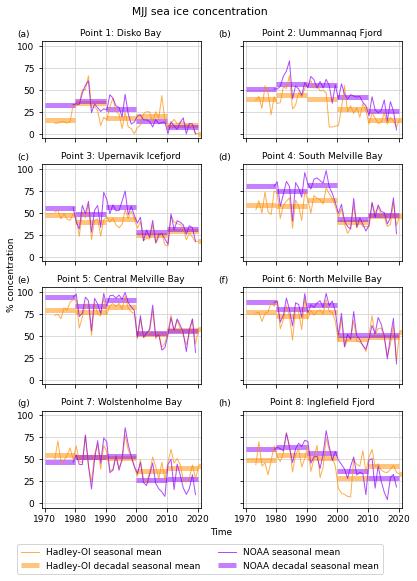

In [25]:
# Plot seasonal sea ice concentration at each point

fig, axs = plt.subplots(
    nrows=4, ncols=2, 
    sharex=True, sharey=True, 
    figsize=(figwidth*2, figwidth*2.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    _, hag, hdg, nag, ndg = cpl.seaIceConcentration(
        nax, coordinate=coordinate, season_start=5, 
        hadley=hadley_sic, noaa=noaa_sic, noaa_var=noaa_var, 
        dec_mean=True, spgrid=True, style=style)
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1, 
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_ylim(bottom=-5, top=105)
    nax.set_xlim(left='1969-01-01', right='2021-01-01')
    nax.set_xticks(
        ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
    nax.set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')
    
cpl.subplotGridLabels(
    fig, 
    title='MJJ sea ice concentration', 
    xlabel='Time', 
    ylabel='% concentration')

# -- add legend for whole figure
fig.legend(handles=[hag, hdg, nag, ndg], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))

plt.tight_layout()

plt.savefig('{}suppfig2_sic_mjj.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}suppfig2_sic_mjj.png'.format(outpath), bbox_inches='tight', dpi=300)

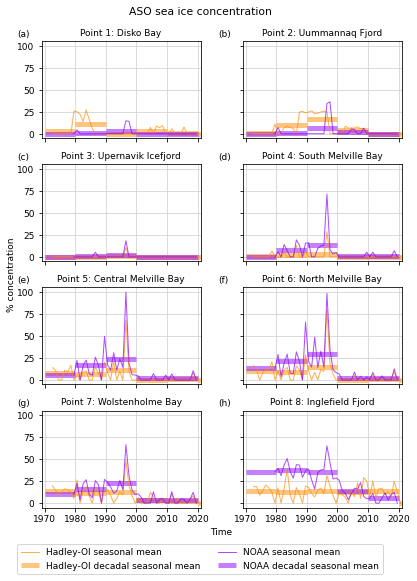

In [26]:
# Plot seasonal sea ice concentration at each point

fig, axs = plt.subplots(
    nrows=4, ncols=2, 
    sharex=True, sharey=True, 
    figsize=(figwidth*2, figwidth*2.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    _, hag, hdg, nag, ndg = cpl.seaIceConcentration(
        nax, coordinate=coordinate, season_start=8, 
        hadley=hadley_sic, noaa=noaa_sic, noaa_var=noaa_var, 
        dec_mean=True, spgrid=True, style=style)
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1, 
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_ylim(bottom=-5, top=105)
    nax.set_xlim(left='1969-01-01', right='2021-01-01')
    nax.set_xticks(
        ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
    nax.set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')
    
cpl.subplotGridLabels(
    fig, 
    title='ASO sea ice concentration', 
    xlabel='Time', 
    ylabel='% concentration')

# -- add legend for whole figure
fig.legend(handles=[hag, hdg, nag, ndg], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))

plt.tight_layout()

plt.savefig('{}suppfig3_sic_aso.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}suppfig3_sic_aso.png'.format(outpath), bbox_inches='tight', dpi=300)

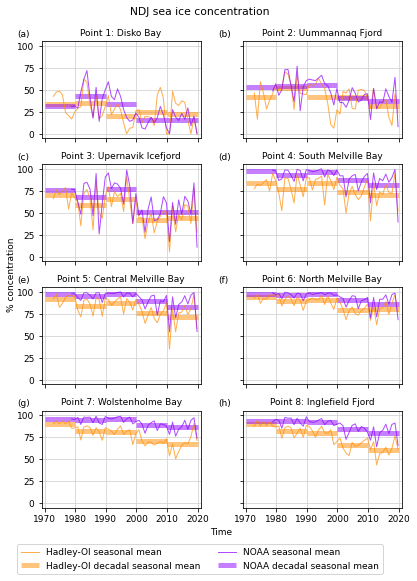

In [27]:
# Plot seasonal sea ice concentration at each point

fig, axs = plt.subplots(
    nrows=4, ncols=2, 
    sharex=True, sharey=True, 
    figsize=(figwidth*2, figwidth*2.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    _, hag, hdg, nag, ndg = cpl.seaIceConcentration(
        nax, coordinate=coordinate, season_start=11, 
        hadley=hadley_sic, noaa=noaa_sic, noaa_var=noaa_var, 
        dec_mean=True, spgrid=True, style=style)
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1, 
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_ylim(bottom=-5, top=105)
    nax.set_xlim(left='1969-01-01', right='2021-01-01')
    nax.set_xticks(
        ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01', '2020-01-01'])
    nax.set_xticklabels(['1970', '1980', '1990', '2000', '2010', '2020'])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')
    
cpl.subplotGridLabels(
    fig, 
    title='NDJ sea ice concentration', 
    xlabel='Time', 
    ylabel='% concentration')

# -- add legend for whole figure
fig.legend(handles=[hag, hdg, nag, ndg], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))

plt.tight_layout()

plt.savefig('{}suppfig4_sic_ndj.{}'.format(outpath, figformat), bbox_inches='tight', dpi=300)
plt.savefig('{}suppfig4_sic_ndj.png'.format(outpath), bbox_inches='tight', dpi=300)

# Discussion

Comparison with Howat and Eddy (2011)

In [28]:
retreating_2000_2010 = met.retreatingGlaciers(all_glaciers, startdate='2000-01-01', enddate='2009-12-31')
stable_2000_2010 = met.stableGlaciers(all_glaciers, 'interplengths', startdate='2000-01-01', enddate='2009-12-31')
print('Between 2000 and 2010, {:.0f}% of glaciers retreated, {:.0f}% were stable.'.format(
    100 * len(retreating_2000_2010) / len(all_glaciers),
    100 * len(stable_2000_2010) / len(all_glaciers)))

retreating_2010_2020 = met.retreatingGlaciers(all_glaciers, startdate='2010-01-01', enddate='2019-12-31')
stable_2010_2020 = met.stableGlaciers(all_glaciers, 'interplengths', startdate='2010-01-01', enddate='2019-12-31')
print('Between 2010 and 2020, {:.0f}% of glaciers retreated, {:.0f}% were stable.'.format(
    100 * len(retreating_2010_2020) / len(all_glaciers),
    100 * len(stable_2010_2020) / len(all_glaciers)))

retreating_2000_2020 = met.retreatingGlaciers(all_glaciers, startdate='2000-01-01', enddate='2019-12-31')
stable_2000_2020 = met.stableGlaciers(all_glaciers, 'interplengths', startdate='2000-01-01', enddate='2019-12-31')
print('Between 2000 and 2020, {:.0f}% of glaciers retreated, {:.0f}% were stable.'.format(
    100 * len(retreating_2000_2020) / len(all_glaciers),
    100 * len(stable_2000_2020) / len(all_glaciers)))

retreating_2000_2010_only = set(retreating_2000_2010.keys()) - set(retreating_2010_2020.keys())
retreating_2010_2020_only = set(retreating_2010_2020.keys()) - set(retreating_2000_2010.keys())
retreating_both_periods = set(retreating_2000_2010.keys()) & set(retreating_2010_2020.keys())

print(f'{100*len(retreating_2000_2010_only)/87:.0f}% of glaciers retreating in 2000-2010 did NOT retreat in 2010-2020')
print(f'{100*len(retreating_2010_2020_only)/87:.0f}% of glaciers retreating in 2010-2020 did NOT retreat in 2000-2010')
print(f'{100*len(retreating_both_periods)/87:.0f}% of glaciers retreated in both decades')

stable_2000_2010_only = set(stable_2000_2010.keys()) - set(stable_2010_2020.keys())
stable_2010_2020_only = set(stable_2010_2020.keys()) - set(stable_2000_2010.keys())
stable_both_periods = set(stable_2000_2010.keys()) & set(stable_2010_2020.keys())

print(f'{100*len(stable_2000_2010_only)/87:.0f}% of glaciers stable in 2000-2010 were NOT stable in 2010-2020')
print(f'{100*len(stable_2010_2020_only)/87:.0f}% of glaciers stable in 2010-2020 were NOT stable in 2000-2010')
print(f'{100*len(stable_both_periods)/87:.0f}% of glaciers were stable in both decades')

Between 2000 and 2010, 85% of glaciers retreated, 15% were stable.
Between 2010 and 2020, 74% of glaciers retreated, 22% were stable.
Between 2000 and 2020, 86% of glaciers retreated, 14% were stable.
16% of glaciers retreating in 2000-2010 did NOT retreat in 2010-2020
5% of glaciers retreating in 2010-2020 did NOT retreat in 2000-2010
69% of glaciers retreated in both decades
6% of glaciers stable in 2000-2010 were NOT stable in 2010-2020
13% of glaciers stable in 2010-2020 were NOT stable in 2000-2010
9% of glaciers were stable in both decades
